In [1]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format='retina'
%matplotlib inline

# 导入数据
data_train = pd.read_csv("dataset/train.csv")
data_train.head()

,time,count_head,count_content,r_unique,r_non_stop,r_non_stop_unique,count_link,count_inter_link,count_images,count_videos,...,sent_pos_min,sent_pos_max,sent_neg_avg,sent_neg_min,sent_neg_max,head_neutral,sent_head,head_neutral_scaled,sent_head_abs,hot
0,203,11,1726.0,0.417829,1.0,0.506143,117,24,48,25,...,0.033333,1.0,-0.311518,-0.800000,-0.050000,0.400000,-0.200000,0.100000,0.200000,0
1,97,9,277.0,0.478261,1.0,0.546448,15,1,10,0,...,0.100000,0.6,-0.291111,-0.400000,-0.155556,0.437500,0.187500,0.062500,0.187500,1
2,43,11,862.0,0.445358,1.0,0.627572,4,2,10,1,...,0.033333,1.0,-0.218421,-0.600000,-0.100000,0.383333,0.041667,0.116667,0.041667,1
3,116,14,439.0,0.533958,1.0,0.703846,12,3,1,1,...,0.100000,1.0,-0.272917,-0.333333,-0.125000,0.000000,0.000000,0.500000,0.000000,1
4,727,12,470.0,0.487124,1.0,0.689922,3,3,7,0,...,0.100000,0.7,-0.123148,-0.200000,-0.050000,0.000000,0.000000,0.500000,0.000000,1


In [2]:
# 检查数据特征，查找是否有缺失值
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31713 entries, 0 to 31712
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 31713 non-null  int64  
 1   count_head           31713 non-null  int64  
 2   count_content        31679 non-null  float64
 3   r_unique             31713 non-null  float64
 4   r_non_stop           31713 non-null  float64
 5   r_non_stop_unique    31713 non-null  float64
 6   count_link           31713 non-null  int64  
 7   count_inter_link     31713 non-null  int64  
 8   count_images         31713 non-null  int64  
 9   count_videos         31713 non-null  int64  
 10  avg_word_len         31713 non-null  float64
 11  count_labels         31713 non-null  int64  
 12  forum_life           31713 non-null  int64  
 13  forum_entertainment  31713 non-null  int64  
 14  forum_business       31713 non-null  int64  
 15  forum_stock          31713 non-null 

<Axes: >

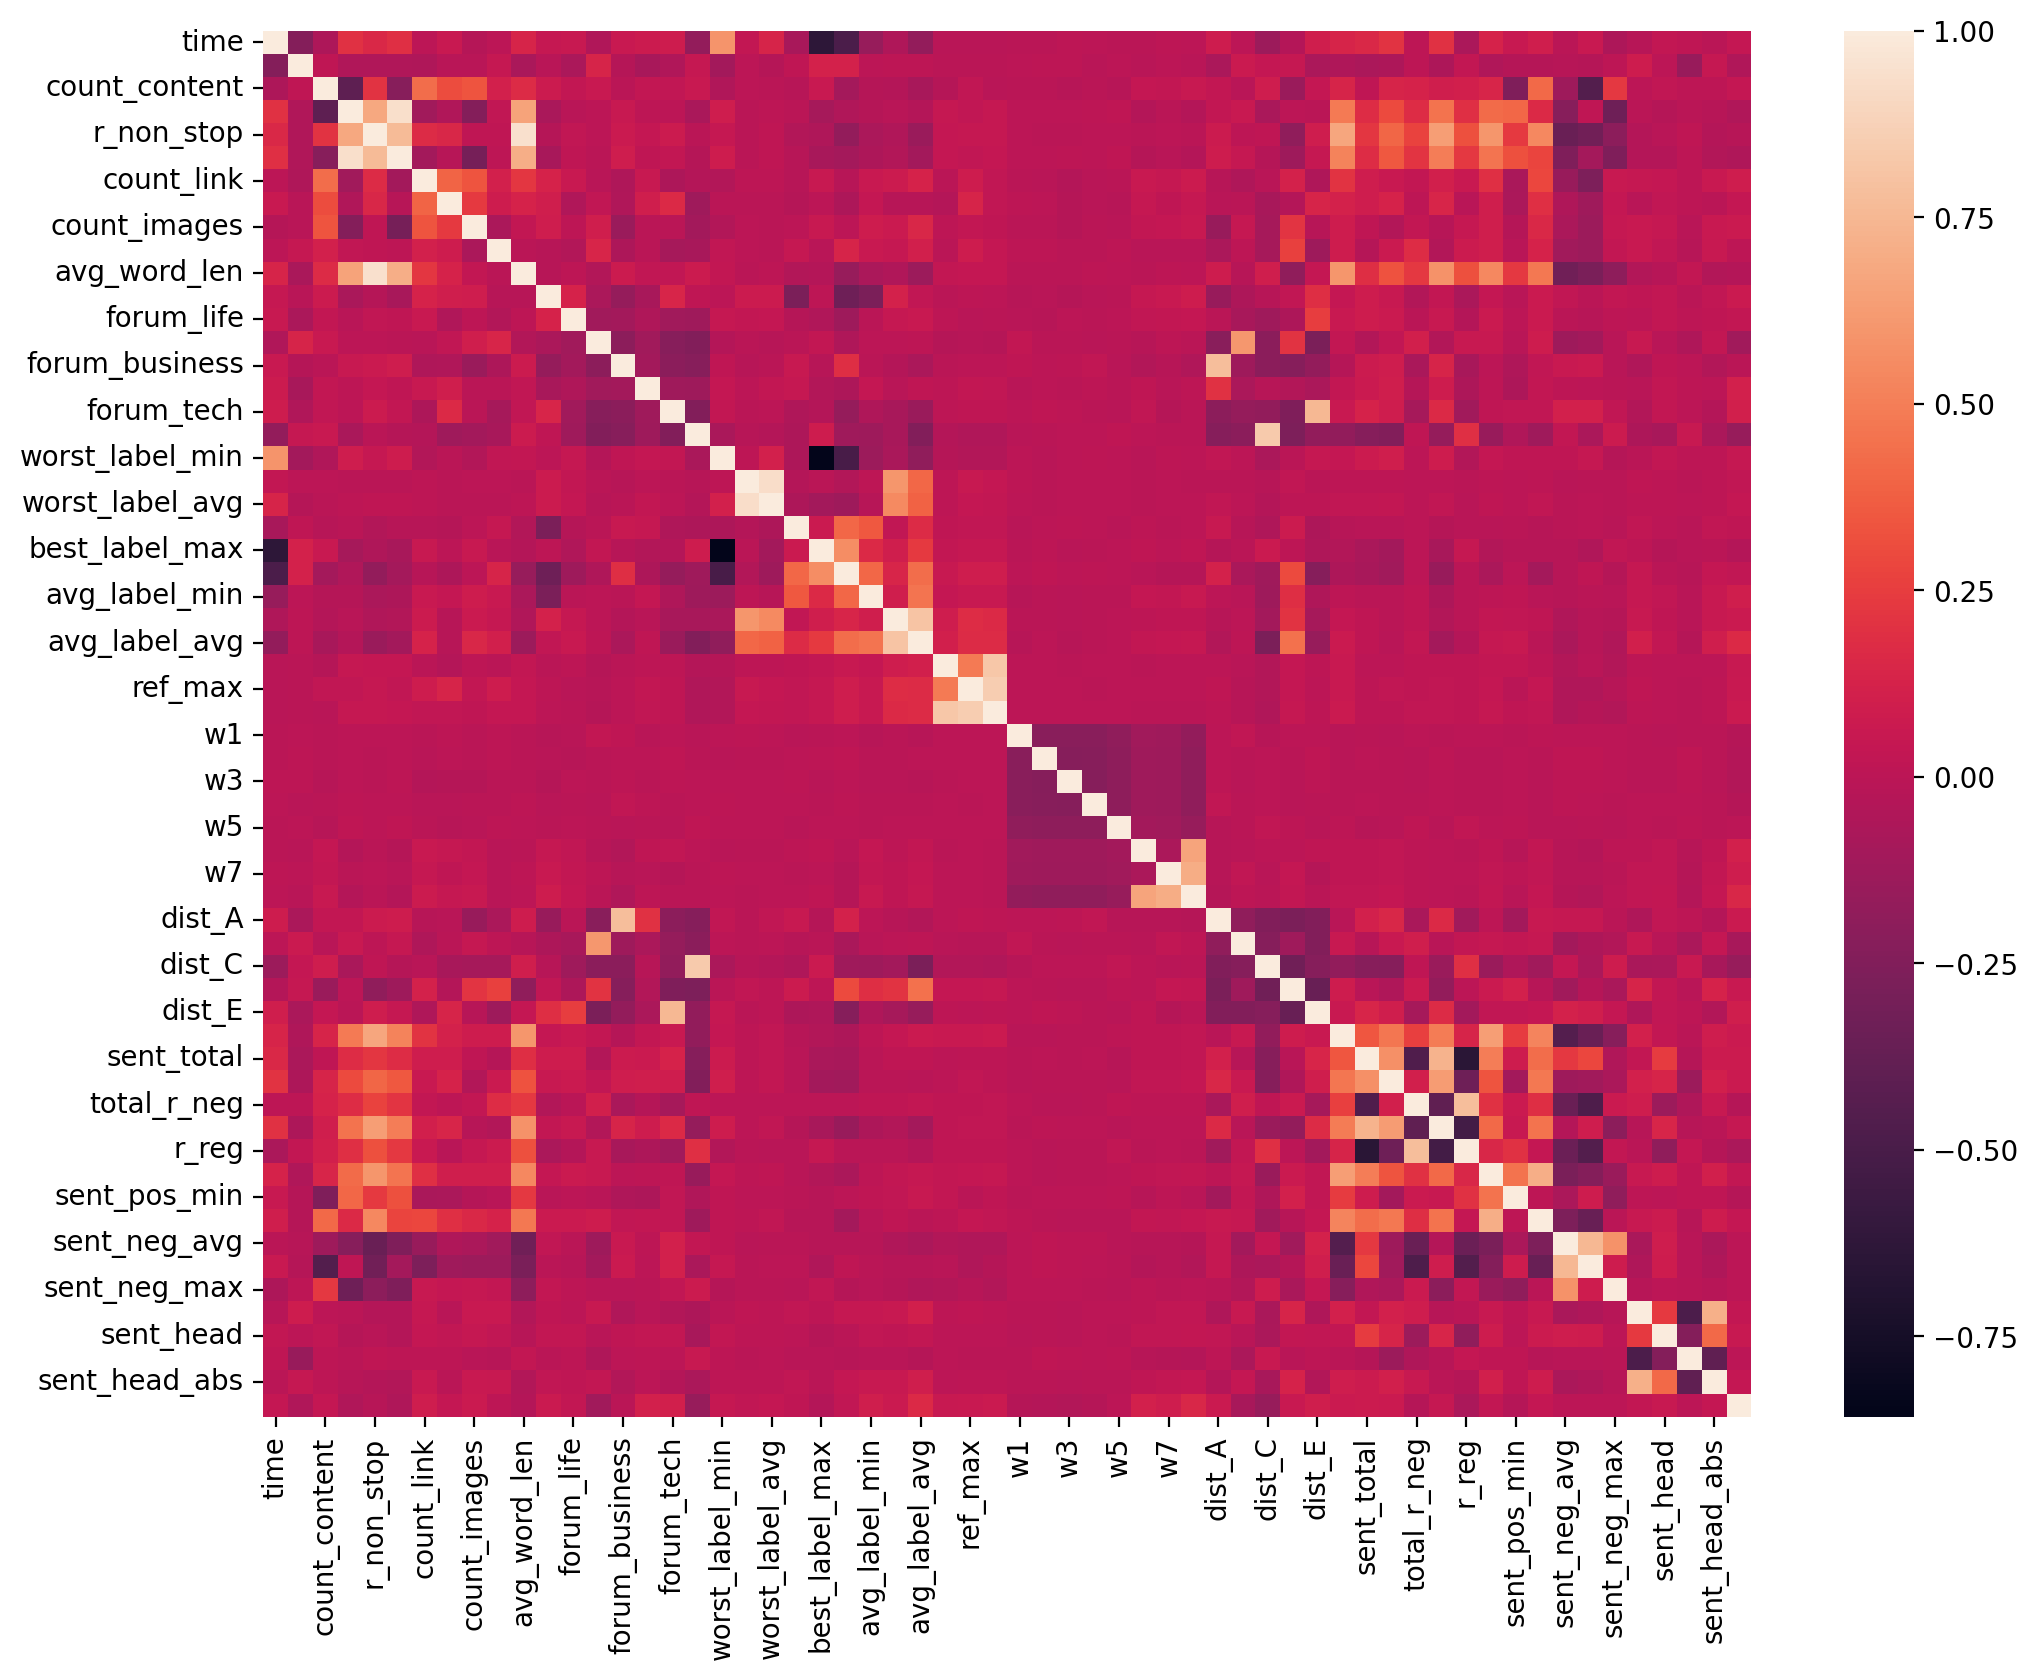

In [3]:
# 由于数据标签太多，对数据标签关于hot进行相关系数的计算，删除相关系数排名最靠后的几个标签
corr_linear = data_train.corr()  # 相关系数矩阵，即给出了任意两个标签之间的相关系数

# 绘制相关系数矩阵的热力图，寻找hot的线性相关系数分布
import seaborn as sns

plt.figure(figsize=(12, 9))
sns.heatmap(corr_linear)

In [4]:
# 计算spearman，kendall相关系数
corr_spearman = data_train.corr("spearman")
corr_kendall = data_train.corr("kendall")
# 取出相关系数中与hot属性有关的
corr_state_linear = corr_linear["hot"]
corr_state_spearman = corr_spearman["hot"]
corr_state_kendall = corr_kendall["hot"]

In [5]:
# 合并所有的相关系数矩阵，形成一个大矩阵
corr_state = corr_state_kendall + corr_state_spearman + corr_state_linear

In [6]:
# 对相关系数取绝对值，并对其进行升序排序后的展示
for i in range(60):
    corr_state[i] = abs(corr_state[i])
corr_state = pd.DataFrame(corr_state)
corr_state = corr_state.sort_values(by="hot")
corr_state.head(3)

/var/folders/4d/xybtwjyj2d3dv4p2_6s1yccw0000gn/T/ipykernel_40298/3072952651.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr_state[i] = abs(corr_state[i])
/var/folders/4d/xybtwjyj2d3dv4p2_6s1yccw0000gn/T/ipykernel_40298/3072952651.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  corr_state[i] = abs(corr_state[i])


,hot
r_non_stop,0.000071
head_neutral_scaled,0.008148
sent_neg_avg,0.010060


In [7]:
data_train = data_train.drop(["head_neutral_scaled", "r_non_stop"], axis=1)
# 删除没有用的数据
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31713 entries, 0 to 31712
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 31713 non-null  int64  
 1   count_head           31713 non-null  int64  
 2   count_content        31679 non-null  float64
 3   r_unique             31713 non-null  float64
 4   r_non_stop_unique    31713 non-null  float64
 5   count_link           31713 non-null  int64  
 6   count_inter_link     31713 non-null  int64  
 7   count_images         31713 non-null  int64  
 8   count_videos         31713 non-null  int64  
 9   avg_word_len         31713 non-null  float64
 10  count_labels         31713 non-null  int64  
 11  forum_life           31713 non-null  int64  
 12  forum_entertainment  31713 non-null  int64  
 13  forum_business       31713 non-null  int64  
 14  forum_stock          31713 non-null  int64  
 15  forum_tech           31713 non-null 

In [21]:
# 取出第一行，转化为json
data_train.iloc[0].to_json()

'{"0":0.2697095436,"1":0.4285714286,"2":0.2223080886,"3":0.4178290008,"4":0.5061425131,"5":0.3848684211,"6":0.3243243243,"7":0.375,"8":0.2747252747,"9":0.6692674135,"10":0.6666666667,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0014879357,"19":0.0021689416,"20":0.0256136606,"21":1.0,"22":0.6447459809,"23":0.703164334,"24":0.0209283256,"25":0.1297018035,"26":0.000136369,"27":0.0302383493,"28":0.0051397288,"29":0.0,"30":0.0,"31":0.0,"32":1.0,"33":0.0,"34":0.0,"35":0.0,"36":0.0,"37":0.0114592658,"38":0.0123332267,"39":0.0115211889,"40":0.9541381869,"41":0.0114374658,"42":0.527463524,"43":0.4932990541,"44":0.2474755841,"45":0.0908544697,"46":0.691489362,"47":0.308510638,"48":0.343800366,"49":0.033333333,"50":1.0,"51":0.688482485,"52":0.2,"53":0.95,"54":0.4,"55":0.4,"56":0.2,"57":0.0}'

In [8]:
# 可以发现， count_content 变量存在空值，下面通过模型建立，填补空缺的count_content值
# from sklearn.ensemble import RandomForestRegressor #使用随机森林回归模型进行模拟
# def set_missing_count_cotent(df):
# count_related = df[['count_content','count_head','r_unique','r_non_stop_unique']]
# 挑出和count_content相关的属性
# known_count= count_related [count_related.count_content.notnull()].values
# 分离出已知年龄的部分作为训练集
# unknown_count= count_related [count_related.count_content.isnull()].values

# x=known_count[:,1:]
# y=known_count[:,0] #取其中count的一列
# rfr=RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
# rfr.fit(x,y)

# x_known= unknown_count[:,1:]
# predict_count_content= rfr.predict(x_known)
# df.loc[(df.count_content.isnull()),'count_content'] = predict_count_content
# 定位count_content为空的部分，跳出空的填入用随机森林模型预测的值

# return df

In [9]:
# data_train = set_missing_count_cotent(data_train) #补齐所有缺失数据
# data_train.info()
# 此时所有的数据都填补好了

In [10]:
# 使用均值填补数据
count_content = data_train["count_content"]
mean = count_content.mean()
data_train = data_train.fillna(mean)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31713 entries, 0 to 31712
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 31713 non-null  int64  
 1   count_head           31713 non-null  int64  
 2   count_content        31713 non-null  float64
 3   r_unique             31713 non-null  float64
 4   r_non_stop_unique    31713 non-null  float64
 5   count_link           31713 non-null  int64  
 6   count_inter_link     31713 non-null  int64  
 7   count_images         31713 non-null  int64  
 8   count_videos         31713 non-null  int64  
 9   avg_word_len         31713 non-null  float64
 10  count_labels         31713 non-null  int64  
 11  forum_life           31713 non-null  int64  
 12  forum_entertainment  31713 non-null  int64  
 13  forum_business       31713 non-null  int64  
 14  forum_stock          31713 non-null  int64  
 15  forum_tech           31713 non-null 

In [11]:
data_train = preprocessing.minmax_scale(data_train)
data_train = pd.DataFrame(data_train)
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.269710,0.428571,0.222308,0.417829,0.506143,0.384868,0.324324,0.375000,0.274725,0.669267,...,0.343800,0.033333,1.0,0.688482,0.200000,0.950000,0.400000,0.400000,0.200000,0.0
1,0.123098,0.333333,0.035677,0.478261,0.546448,0.049342,0.013514,0.078125,0.000000,0.601633,...,0.314286,0.100000,0.6,0.708889,0.600000,0.844444,0.437500,0.593750,0.187500,1.0
2,0.048409,0.428571,0.111025,0.445358,0.627572,0.013158,0.027027,0.078125,0.010989,0.606327,...,0.337240,0.033333,1.0,0.781579,0.400000,0.900000,0.383333,0.520833,0.041667,1.0
3,0.149378,0.571429,0.056543,0.533958,0.703846,0.039474,0.040541,0.007812,0.010989,0.596420,...,0.364560,0.100000,1.0,0.727083,0.666667,0.875000,0.000000,0.500000,0.000000,1.0
4,0.994467,0.476190,0.060536,0.487124,0.689922,0.009868,0.040541,0.054688,0.000000,0.550412,...,0.359902,0.100000,0.7,0.876852,0.800000,0.950000,0.000000,0.500000,0.000000,1.0


In [12]:
X = data_train.iloc[:, 0:57]
Y = data_train.iloc[:, 57]
# 分割训练集，测试集
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=666)

In [13]:
# 使用KNN进行预测
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(xtrain, ytrain)
print(knn.score(xtest.astype(int), ytest.astype(int)))

0.5776446476430711


In [14]:
# 使用朴素贝叶斯方法进行预测
from sklearn.naive_bayes import GaussianNB

Gnb = GaussianNB()
Gnb.fit(xtrain, ytrain)
print(Gnb.score(xtest, ytest))

0.5880498186977771


### 使用随机森林方法进行预测, 调参 n_estimators


In [16]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
from sklearn.ensemble import RandomForestClassifier

score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0, 250, 10):
    rfc = RandomForestClassifier(n_estimators=i + 1, random_state=90)
    score = cross_val_score(rfc, xtrain, ytrain, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print(
    "最大得分：{}".format(score_max),
    "子树数量为：{}".format(score_lt.index(score_max) * 10 + 1),
)

# 绘制学习曲线
x = np.arange(1, 251, 10)
plt.subplot(111)
plt.plot(x, score_lt, "r-")
plt.show()

KeyboardInterrupt: 

0.6698856917619236 147


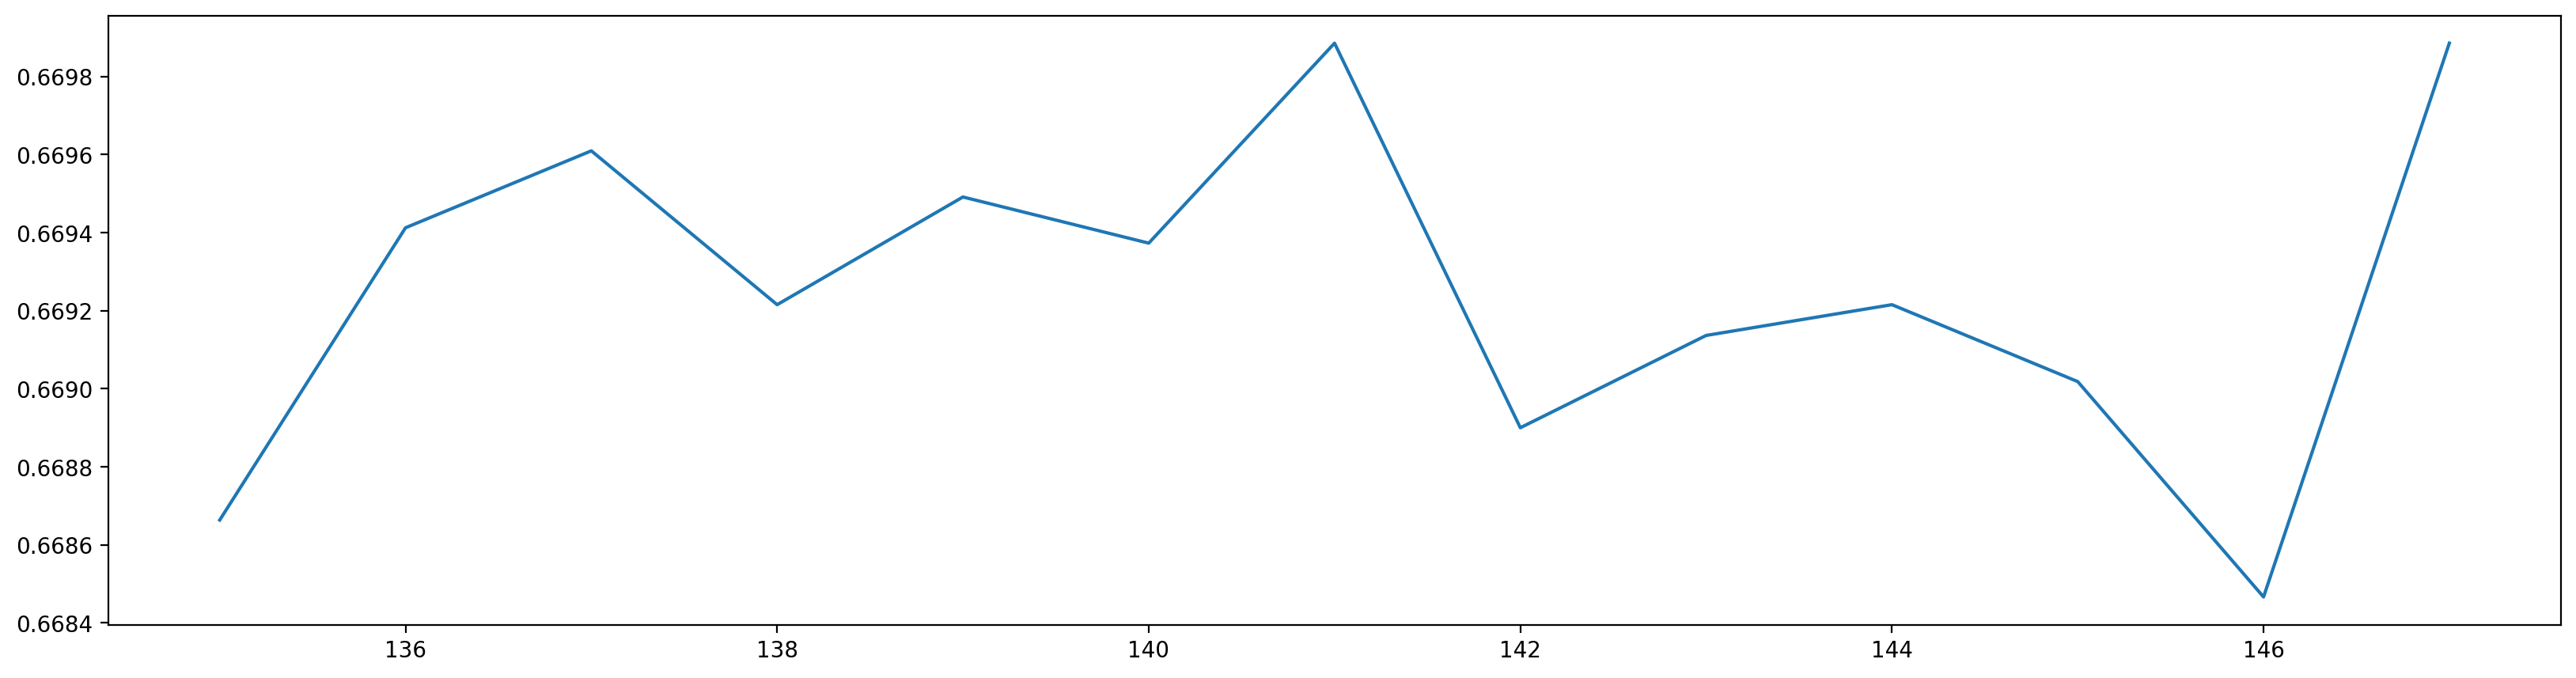

In [ ]:
# 2.确定好了范围之后，进一步绘制学习曲线
scorel = []
# 由于我们上面得知的最好的n_estimators大概在141左右，所以我们可以探索135-148之间有没有更好的结果
for i in range(135, 148):
    rfc = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=70)
    score = cross_val_score(rfc, xtrain, ytrain, cv=10).mean()
    scorel.append(score)
    # 打印出最大的打分和在85到95中，分数最高的时候所对应的索引
print(max(scorel), ([*range(135, 148)][scorel.index(max(scorel))]))
plt.figure(figsize=[20, 5])
plt.plot(range(135, 148), scorel)
plt.show()
# 从下面的图中可以知道n_estimators调整为144的时候，我们的随机森林将会有更好的表现

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=141, n_jobs=-1, random_state=70)
rfc.fit(xtrain, ytrain)
score = cross_val_score(rfc, xtrain, ytrain, cv=10).mean()
print(score)

0.6698856917619235


In [17]:
# 保存模型为pkl文件
import joblib

joblib.dump(rfc, "rfc.pkl")

['rfc.pkl']

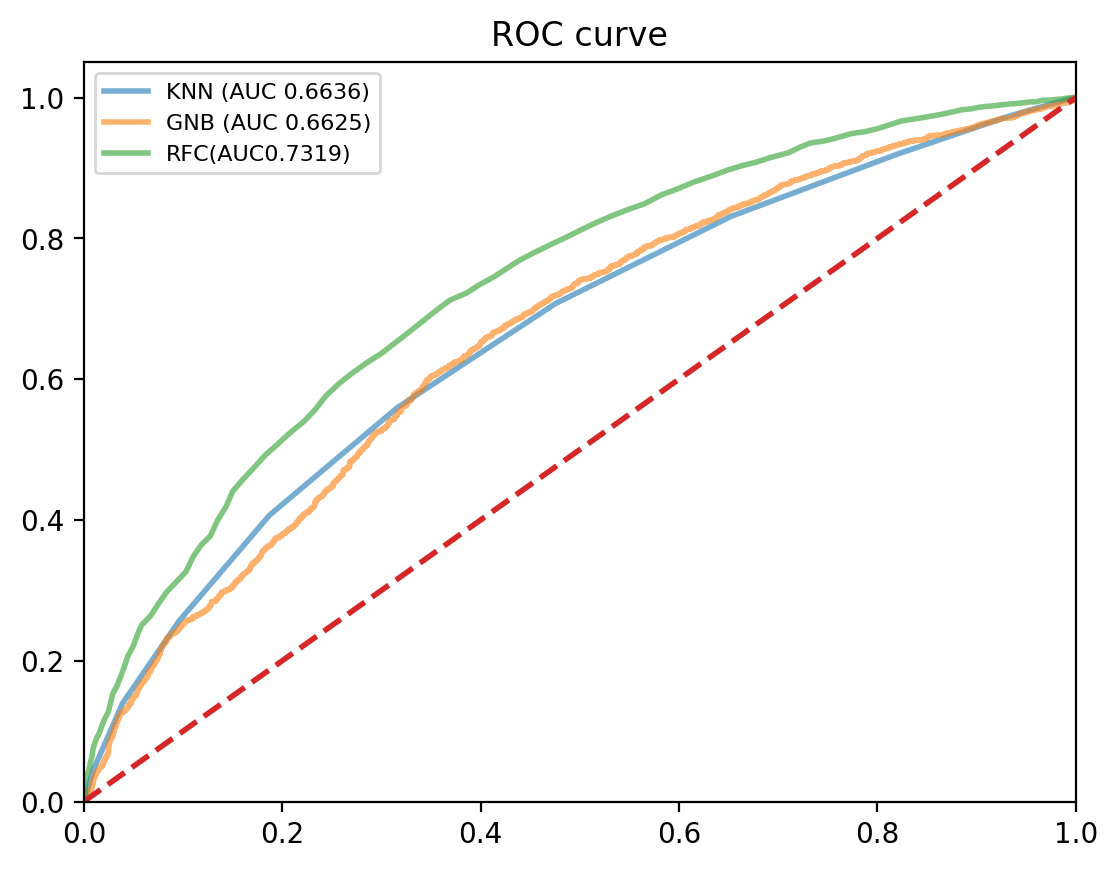

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

y1_valid_score_knn = knn.predict_proba(xtest)
y1_valid_score_gnb = Gnb.predict_proba(xtest)
y1_valid_score_rfc = rfc.predict_proba(xtest)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(ytest, y1_valid_score_knn[:, 1])
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(ytest, y1_valid_score_gnb[:, 1])
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(ytest, y1_valid_score_rfc[:, 1])

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
roc_auc_rfc = auc(
    fpr_rfc,
    tpr_rfc,
)

plt.plot(fpr_knn, tpr_knn, fpr_gnb, tpr_gnb, fpr_rfc, tpr_rfc, lw=2, alpha=0.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title("ROC curve")
plt.legend(
    [
        "KNN (AUC {:.4f})".format(roc_auc_knn),
        "GNB (AUC {:.4f})".format(roc_auc_gnb),
        "RFC(AUC{:.4f})".format(roc_auc_rfc),
    ],
    fontsize=8,
    loc=2,
)

In [ ]:
# 使用预测集进行预测 读入数据
data_test = pd.read_csv("dataset/test.csv")
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7930 entries, 0 to 7929
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 7930 non-null   int64  
 1   count_head           7930 non-null   int64  
 2   count_content        7924 non-null   float64
 3   r_unique             7930 non-null   float64
 4   r_non_stop           7930 non-null   float64
 5   r_non_stop_unique    7930 non-null   float64
 6   count_link           7930 non-null   int64  
 7   count_inter_link     7930 non-null   int64  
 8   count_images         7930 non-null   int64  
 9   count_videos         7930 non-null   int64  
 10  avg_word_len         7930 non-null   float64
 11  count_labels         7930 non-null   int64  
 12  forum_life           7930 non-null   int64  
 13  forum_entertainment  7930 non-null   int64  
 14  forum_business       7930 non-null   int64  
 15  forum_stock          7930 non-null   i

In [ ]:
data_test = data_test.drop(["head_neutral_scaled", "r_non_stop"], axis=1)
# 删除没有用的数据
count_content_test = data_test["count_content"]
mean_test = count_content_test.mean()
data_test = data_test.fillna(mean_test)  # 用均值补全nan值
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7930 entries, 0 to 7929
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 7930 non-null   int64  
 1   count_head           7930 non-null   int64  
 2   count_content        7930 non-null   float64
 3   r_unique             7930 non-null   float64
 4   r_non_stop_unique    7930 non-null   float64
 5   count_link           7930 non-null   int64  
 6   count_inter_link     7930 non-null   int64  
 7   count_images         7930 non-null   int64  
 8   count_videos         7930 non-null   int64  
 9   avg_word_len         7930 non-null   float64
 10  count_labels         7930 non-null   int64  
 11  forum_life           7930 non-null   int64  
 12  forum_entertainment  7930 non-null   int64  
 13  forum_business       7930 non-null   int64  
 14  forum_stock          7930 non-null   int64  
 15  forum_tech           7930 non-null   i

In [ ]:
import sklearn.preprocessing as preprocessing

data_test = preprocessing.minmax_scale(data_test)
data_test = pd.DataFrame(data_test)

In [ ]:
predictions = rfc.predict(data_test)

result = pd.DataFrame(predictions)

In [ ]:
# 查看预测准确率


0.6723947658836513


In [ ]:
# 生成csv文件
result.to_csv("Results.csv", encoding="utf-8", index=False, header=False)